# Classification

## 라이브러리 불러오기 및 경로설정

In [2]:
# Seed
import torch
import numpy as np
import random

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize

from PIL import Image
import PIL

import os
from glob import glob
import cv2

from torch.optim import Adam

In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

## Model 정의

In [4]:
class VGG11(nn.Module):
  def __init__(self, num_classes=1000):
    super(VGG11, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    '''==========================================================='''
    '''======================== TO DO (1) ========================'''
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
    '''======================== TO DO (1) ========================'''
    '''==========================================================='''
    

    # Fully Connected Classifier Part
    self.fc1      = nn.Linear(512 * 7 * 7, 4096)
    self.dropout1 = nn.Dropout()
    
    '''==========================================================='''
    '''======================== TO DO (2) ========================'''
    self.fc2      = nn.Linear(4096, 4096)
    self.dropout2 = nn.Dropout()
    
    self.fc3      = nn.Linear(4096, num_classes)
    '''======================== TO DO (2) ========================'''
    '''==========================================================='''
    

  def forward(self, x):
    # Convolution Feature Extraction Part
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)
    x = self.pool5(x)

    # Fully Connected Classifier Part
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout2(x)
    
    x = self.fc3(x)
    return x

## Hyper-parameters 

In [5]:
data_root = '/opt/ml/input/data/train/images'
log_dir   = '/opt/ml/input/log'

batch_size = 32 # 8
lr = 1e-4
input_size = 224

## Dataset

In [6]:
class MaskDataset(Dataset):
  def __init__(self, data_root, is_Train=True, input_size=224, transform=None):
    super(MaskDataset, self).__init__()

    self.img_list = self._load_img_list(data_root, is_Train)
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]
    
    # Image Loading
    img = PIL.Image.open(img_path)
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img/255.
#     plt.imshow(img)

    if self.transform:
      img = self.transform(img) # 에러

    # Ground Truth
    label = self._get_class_idx_from_img_name(img_path)

    return img, label

  def __len__(self):
    return self.len

  def _load_img_list(self, data_root, is_Train): # 여기
    # Change the name of directory which has inconsistent naming rule.
    full_img_list = glob(data_root + '/*')
    for dir in full_img_list:
      dirname = os.path.basename(dir)
      if '-1' in dirname:
        os.rename(dir, dir.replace(dirname, dirname.replace('-1', '1')))
    
    # ID < 1000 for Training (N=721)
    # 1000 < ID < 1050 for Validation (N=63)  # 여기
    img_list = []
    for dir in glob(data_root + '/*'):
      if is_Train and (self._load_img_ID(dir) <= 5100): 
        img_list.extend(glob(dir+'/*'))
      elif not is_Train and (5100 < self._load_img_ID(dir) < 7960):
        img_list.extend(glob(dir+'/*'))

    return img_list

  def _load_img_ID(self, img_path):
    ret = os.path.basename(img_path).split('_')[0].split('-')[0]
    return int(ret)

  def _get_class_idx_from_img_name(self, img_path):
    img_name = os.path.basename(img_path) 
#     print(img_name.split('_')[-1].split('.')[0])
#     print(img_path)
    ret =int(img_name.split('_')[-1].split('.')[0])
    return ret

## Dataset and Data Loader

In [7]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224,224)),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose(
    [transforms.Resize((244, 244)),
     transforms.CenterCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])


train_dataset = MaskDataset(data_root, is_Train=True, input_size=input_size, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

# print(train_dataset.len)
# print(train_dataset.img_list[0])


valid_dataset = MaskDataset(data_root, is_Train=False, input_size=input_size, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

print(valid_dataset.len)

4732


In [8]:
# Misc

class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

## fine tuning

In [9]:
from torchvision.models import vgg11

'''======================== TO DO Setting ========================'''
pretrained = True # True of False
'''==============================================================='''

model = vgg11(pretrained)
model.classifier[6] = nn.Linear(in_features=4096, out_features=18, bias=True) # 여기
model.cuda()

# Freeze the feature extracting convolution layers
for param in model.features.parameters():
    param.requires_grad = False

## Loss function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

## Main

In [11]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'fine_tuned_train_log.csv'), 'w') as log:
  # Training
  for iter, (img, label) in enumerate(train_loader):
    print(iter)
    '''================================================================'''
    '''======================== TO DO Main (1) ========================'''
    # optimizer에 저장된 미분값을 0으로 초기화
    optimizer.zero_grad()

    # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
    img, label = img.to(device='cuda').float(), label.to(device='cuda')

    # 모델에 이미지 forward
    pred_logit = model(img)

    # loss 값 계산
    loss = criterion(pred_logit, label)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Accuracy 계산
    pred_label = pred_logit.argmax(1)
#     print(label.shape[0])
    acc = torch.div((pred_label == label).sum(), float(label.shape[0]))
#     acc = (pred_label == label).sum() / label.shape[0]
    '''======================== TO DO Main (1) ========================'''
    '''================================================================'''

    train_loss = loss.item()
    train_acc = acc

    # Validation for every 20 epoch
    if (iter % 20 == 0) or (iter == len(train_loader)-1):
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in valid_loader:
        '''================================================================'''
        '''======================== TO DO Main (2) ========================'''
        # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
        img, label = img.to(device='cuda').float(), label.to(device='cuda')

        # 모델에 이미지 forward (gradient 계산 X)
        with torch.no_grad():
            pred_logit = model(img)

        # loss 값 계산
        loss = criterion(pred_logit, label)

        # Accuracy 계산
        pred_label = pred_logit.argmax(1)
        acc = torch.div((pred_label == label).sum(), float(label.shape[0]))
#         acc = (pred_label == label).sum() / label.shape[0]
        '''======================== TO DO Main (2) ========================'''
        '''================================================================'''

        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iter, len(train_loader), train_loss, train_acc, valid_loss, valid_acc))
      
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iter, train_loss, train_acc, valid_loss, valid_acc))

0
Iter [  0/435] | Train Loss 2.9626 | Train Acc 0.1250 | Valid Loss 2.7623 | Valid Acc 0.1388
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Iter [ 20/435] | Train Loss 1.3249 | Train Acc 0.7188 | Valid Loss 2.1393 | Valid Acc 0.2880
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Iter [ 40/435] | Train Loss 1.1193 | Train Acc 0.7188 | Valid Loss 1.6356 | Valid Acc 0.4801
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
Iter [ 60/435] | Train Loss 0.9162 | Train Acc 0.6562 | Valid Loss 1.3908 | Valid Acc 0.5241
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
Iter [ 80/435] | Train Loss 0.6177 | Train Acc 0.7812 | Valid Loss 1.5225 | Valid Acc 0.4854
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Iter [100/435] | Train Loss 0.7564 | Train Acc 0.7500 | Valid Loss 1.5010 | Valid Acc 0.4928
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
Iter [120/435] | Train Loss 0.9937 | Train Acc 0.6562 | Valid Loss 1

## Training Log Visualization

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# Load log file
# scratch_train_log = pd.read_csv(os.path.join(log_dir, 'scratch_train_log.csv'), index_col=0, header=None)
fine_tuned_train_log = pd.read_csv(os.path.join(log_dir, 'fine_tuned_train_log.csv'), index_col=0, header=None)

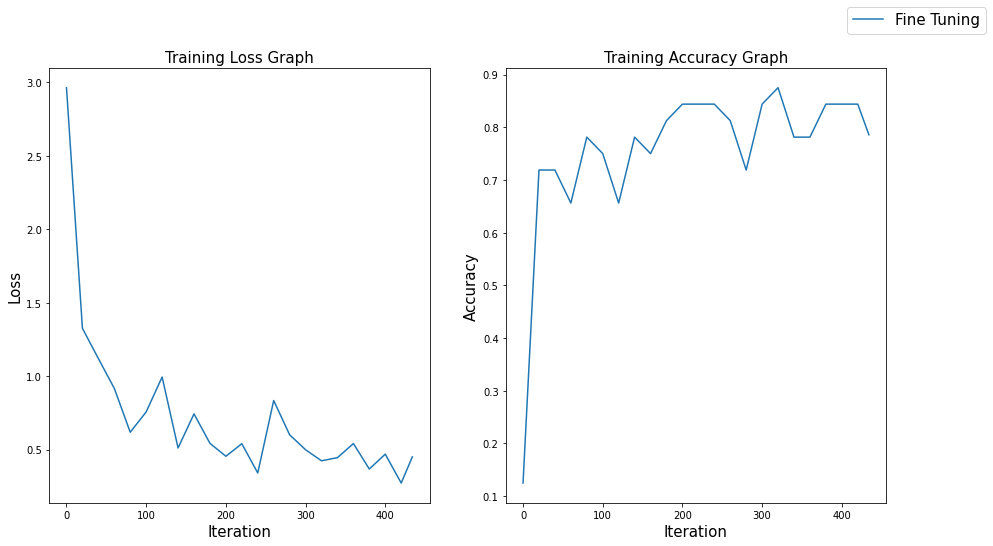

In [14]:
# Visualize training log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

# ax1.plot(scratch_train_log.iloc[:,0], label='Scratch Training')
ax1.plot(fine_tuned_train_log.iloc[:,0], label='Fine Tuning')
ax1.set_title('Training Loss Graph', fontsize=15)
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

# ax2.plot(scratch_train_log.iloc[:,1], label='Scratch Training')
ax2.plot(fine_tuned_train_log.iloc[:,1], label='Fine Tuning')
ax2.set_title('Training Accuracy Graph', fontsize=15)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.show()